In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import copy
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output


pd.options.display.float_format = '{:20,.15f}'.format
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

current_month = '04'
next_month = '05'

STATION_NR = 24

start_time=f'2023-{current_month}-01 00:00:00'
stop_time=f'2023-{next_month}-01 00:00:00'

#start_time=f'2023-01-01 00:00:00'
#stop_time=f'2024-01-01 00:00:00'

tracker_initial = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db', already_calculated=True)
tracker = copy.deepcopy(tracker_initial) # make a new instance of the tracker
print(len(tracker.flights), len(tracker.flights_distinct))
tracker.flights_distinct

69152 394


,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000,2023-04-01 01:01:07.500000,33.100000000000001,10.800000000000001,15.000000000000000
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000,2023-04-01 03:40:13.900000,99.900000000000006,7.800000000000000,52.000000000000000
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000,2023-04-01 18:48:53.900000,89.900000000000006,7.200000000000000,57.000000000000000
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000,2023-04-01 03:05:38.800000,72.799999999999997,7.700000000000000,49.000000000000000
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000,2023-04-01 03:40:39.000000,32.899999999999999,10.100000000000000,15.000000000000000
...,...,...,...,...,...,...,...,...,...
389,1831,ETD93C,2023-04-30,2023.05.01-051342.db,2023-04-30 07:54:18.700000,2023-04-30 08:01:50.900000,134.099999999999994,9.199999999999999,26.000000000000000
390,1832,SAS936,2023-04-30,2023.05.01-051342.db,2023-04-30 10:36:26.000000,2023-04-30 10:56:51.900000,11.900000000000000,10.199999999999999,14.000000000000000
391,1833,SKIER71,2023-04-30,2023.05.01-051342.db,2023-04-30 12:55:21.500000,2023-04-30 15:07:20.000000,0.600000000000000,0.000000000000000,47.000000000000000
392,1834,SERGB,2023-04-30,2023.05.01-051342.db,2023-04-30 17:35:48.300000,2023-04-30 17:51:42.900000,66.099999999999994,10.500000000000000,2.000000000000000


In [2]:
#save the flights_distinct table with header information joined
con = sqlite3.connect('./header_files_for_time_range/header_2023')

# Write the DataFrame to the SQLite database
tables = pd.read_sql_query(f'Select name from sqlite_master where type = "table"', con)

# Close the database connection
con.close()
tables

,name
0,all_triggers_2023_03
1,all_triggers_2023_04
2,all_triggers_2023_06
3,all_triggers_2023_07
4,all_triggers_2023_08
5,all_triggers_2023_09
6,all_triggers_2023_10
7,all_triggers_2023_11
8,all_triggers_2023_05


In [3]:
'''con = sqlite3.connect('./header_files_for_time_range/header_2023')

temp_df = pd.read_sql_query(f'Select * from all_triggers_2023_04 where lt_triggers = 1', con)

con.close()
print(len(temp_df))'''

temp_df = pd.DataFrame()
con = sqlite3.connect('./header_files_for_time_range/header_2023')
for table in ['all_triggers_2023_04']:
    try:
        temp = pd.read_sql_query(f'Select * From {table} where station_number = {STATION_NR} ', con)
        if(len(temp_df == 0)):
            temp_df = temp
        else:
            temp_df = pd.concat([temp_df, temp], ignore_index=True, sort=False)
    except:
        print(f'Some problem with {table}')
con.close()
temp_df

,index,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers
0,1282432,24,932,3444,"1,682,069,939.629889011383057",0,0,1
1,1282433,24,932,3445,"1,682,069,943.986675262451172",0,1,0
2,1282434,24,932,3446,"1,682,069,944.504499912261963",0,1,0
3,1282435,24,932,3447,"1,682,069,944.584727048873901",0,1,0
4,1282436,24,932,3448,"1,682,069,946.651057481765747",0,1,0
...,...,...,...,...,...,...,...,...
289873,2614643,24,1043,476,"1,682,878,836.240382194519043",0,1,0
289874,2614644,24,1043,477,"1,682,878,836.943353652954102",0,1,0
289875,2614645,24,1043,478,"1,682,878,838.033209800720215",0,1,0
289876,2614646,24,1043,479,"1,682,878,839.666851282119751",0,1,0


In [4]:
# add fk_date_flightnumber
flights_distinct = tracker.flights_distinct
flights_distinct = sqldf(''' 
SELECT
    *
    ,date || '_' || flightnumber as fk_date_flightnumber
FROM flights_distinct
''')
flights = tracker.flights
flights = sqldf(''' 
SELECT
    *
    ,date(readtime) || '_' || flightnumber as fk_date_flightnumber
FROM flights
''')


flights_distinct['mintime'] = pd.to_datetime(flights_distinct.mintime).dt.tz_localize('UTC')
flights_distinct['maxtime'] = pd.to_datetime(flights_distinct.maxtime).dt.tz_localize('UTC')

flights_distinct['mintime_millis'] = flights_distinct.mintime.astype(np.int64) // 10 ** 6
flights_distinct['maxtime_millis'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 6

flights_distinct['mintime_sec'] = flights_distinct.mintime.astype(np.int64) // 10 ** 9
flights_distinct['maxtime_sec'] = flights_distinct.maxtime.astype(np.int64) // 10 ** 9

flights_distinct['ID'] = flights_distinct.index

temp_df['trigger_time_millis'] = (temp_df['trigger_time'] * (10 ** 3)).astype(np.int64)
temp_df['trigger_time_sec'] = (temp_df['trigger_time']).astype(np.int64)

flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta,fk_date_flightnumber,mintime_millis,maxtime_millis,mintime_sec,maxtime_sec,ID
0,3261,DLH9922,2023-04-01,2023.04.01-051111.db,2023-04-01 00:42:32.100000+00:00,2023-04-01 01:01:07.500000+00:00,33.100000000000001,10.800000000000001,15.000000000000000,2023-04-01_DLH9922,1680309752100,1680310867500,1680309752,1680310867,0
1,3262,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 00:59:37.100000+00:00,2023-04-01 03:40:13.900000+00:00,99.900000000000006,7.800000000000000,52.000000000000000,2023-04-01_N/A,1680310777100,1680320413900,1680310777,1680320413,1
2,3263,N/A,2023-04-01,2023.04.01-051111.db,2023-04-01 05:21:28.400000+00:00,2023-04-01 18:48:53.900000+00:00,89.900000000000006,7.200000000000000,57.000000000000000,2023-04-01_N/A,1680326488400,1680374933900,1680326488,1680374933,2
3,3264,CSN312,2023-04-01,2023.04.01-051111.db,2023-04-01 02:49:29.100000+00:00,2023-04-01 03:05:38.800000+00:00,72.799999999999997,7.700000000000000,49.000000000000000,2023-04-01_CSN312,1680317369100,1680318338800,1680317369,1680318338,3
4,3265,DLH491,2023-04-01,2023.04.01-051111.db,2023-04-01 03:20:48.200000+00:00,2023-04-01 03:40:39+00:00,32.899999999999999,10.100000000000000,15.000000000000000,2023-04-01_DLH491,1680319248200,1680320439000,1680319248,1680320439,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,1831,ETD93C,2023-04-30,2023.05.01-051342.db,2023-04-30 07:54:18.700000+00:00,2023-04-30 08:01:50.900000+00:00,134.099999999999994,9.199999999999999,26.000000000000000,2023-04-30_ETD93C,1682841258700,1682841710900,1682841258,1682841710,389
390,1832,SAS936,2023-04-30,2023.05.01-051342.db,2023-04-30 10:36:26+00:00,2023-04-30 10:56:51.900000+00:00,11.900000000000000,10.199999999999999,14.000000000000000,2023-04-30_SAS936,1682850986000,1682852211900,1682850986,1682852211,390
391,1833,SKIER71,2023-04-30,2023.05.01-051342.db,2023-04-30 12:55:21.500000+00:00,2023-04-30 15:07:20+00:00,0.600000000000000,0.000000000000000,47.000000000000000,2023-04-30_SKIER71,1682859321500,1682867240000,1682859321,1682867240,391
392,1834,SERGB,2023-04-30,2023.05.01-051342.db,2023-04-30 17:35:48.300000+00:00,2023-04-30 17:51:42.900000+00:00,66.099999999999994,10.500000000000000,2.000000000000000,2023-04-30_SERGB,1682876148300,1682877102900,1682876148,1682877102,392


In [5]:
fk_timestamp = pd.DataFrame(columns = ['trigger_time_sec'], data = range(flights_distinct.mintime_millis.min() // 1000, flights_distinct.maxtime_millis.max() // 1000, 1))
fk_timestamp

,trigger_time_sec
0,1680309752
1,1680309753
2,1680309754
3,1680309755
4,1680309756
...,...
2569084,1682878836
2569085,1682878837
2569086,1682878838
2569087,1682878839


In [6]:
query = ''' 
SELECT
    count(trigger_time_sec) as sum_triggers_per_second
    --,station_number
    ,trigger_time_sec
    --,CASE 
    --    WHEN force_triggers = 1 THEN 1
    --    WHEN lt_triggers = 1 THEN 2
    --    WHEN radiant_triggers = 1 THEN 3
    --    ELSE -1
    --END AS trigger_type
    --,force_triggers
    --,lt_triggers
    --,radiant_triggers
    --,trigger_time_millis
FROM temp_df
--GROUP BY station_number, trigger_time_sec

GROUP BY trigger_time_sec
'''

test = sqldf(query)
test

,sum_triggers_per_second,trigger_time_sec
0,1,1682069939
1,1,1682069943
2,2,1682069944
3,1,1682069946
4,1,1682069947
...,...,...
136818,2,1682878832
136819,1,1682878833
136820,2,1682878836
136821,1,1682878838


In [7]:
fk_timestamp = fk_timestamp.merge(test, on=['trigger_time_sec'], how='left')

In [8]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,NaN
1,1680309753,NaN
2,1680309754,NaN
3,1680309755,NaN
4,1680309756,NaN
...,...,...
2569084,1682878836,2.000000000000000
2569085,1682878837,NaN
2569086,1682878838,1.000000000000000
2569087,1682878839,2.000000000000000


In [9]:
fk_timestamp.sum_triggers_per_second.fillna(0, inplace = True)
#fk_timestamp.station_number.fillna(-1, inplace=True)
#fk_timestamp.force_triggers.fillna(-1, inplace=True)

In [10]:
fk_timestamp

,trigger_time_sec,sum_triggers_per_second
0,1680309752,0.000000000000000
1,1680309753,0.000000000000000
2,1680309754,0.000000000000000
3,1680309755,0.000000000000000
4,1680309756,0.000000000000000
...,...,...
2569084,1682878836,2.000000000000000
2569085,1682878837,0.000000000000000
2569086,1682878838,1.000000000000000
2569087,1682878839,2.000000000000000


In [11]:
fk_timestamp['sum_triggers_per_second'] = fk_timestamp.sum_triggers_per_second.astype('uint16')

In [12]:
# join header information on flights_distinct
query = '''
SELECT 
    flightnumber
    ,fk_date_flightnumber
    --,station_number
    ,sum_triggers_per_second
    ,trigger_time_sec
FROM flights_distinct
LEFT JOIN ( 
            SELECT
                *
            FROM fk_timestamp
)t0

ON t0.trigger_time_sec > flights_distinct.mintime_sec
AND t0.trigger_time_sec < flights_distinct.maxtime_sec
WHERE trigger_time_sec is not null
and min_r < 50
--AND force_triggers = 0
--AND lt_triggers = 1
--AND radiant_triggers = 1
--GROUP BY fk_date_flightnumber, station_number, trigger_time_sec
GROUP BY fk_date_flightnumber, trigger_time_sec
'''

result = sqldf(query)
clear_output(wait=True)
result

,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec
0,CPA095,2023-04-01_CPA095,0,1680338251
1,CPA095,2023-04-01_CPA095,0,1680338252
2,CPA095,2023-04-01_CPA095,0,1680338253
3,CPA095,2023-04-01_CPA095,0,1680338254
4,CPA095,2023-04-01_CPA095,0,1680338255
...,...,...,...,...
339659,SKIER71,2023-04-30_SKIER71,0,1682867235
339660,SKIER71,2023-04-30_SKIER71,2,1682867236
339661,SKIER71,2023-04-30_SKIER71,0,1682867237
339662,SKIER71,2023-04-30_SKIER71,0,1682867238


In [13]:
#-------------------------------------------------------------------------------------------------------------------
def part_lin(x, times, r):
    return_linspace = []
    for element in x:
        #print()
        #print(times, element)
        #print(np.where(times <= element))
        #print()
        index = np.where(times <= element)[0][-1]
        if index >= (len(times) - 1):
            index = index - 1
            print(f'Index {index} out of range {len(times) - 1}')
        y2 = r.iloc[index+1]
        y1 = r.iloc[index]
        x2 = times.iloc[index+1]
        x1 = times.iloc[index]
        m = (y2 - y1) / (x2 - x1)
        t = y2 - m * x2
        return_linspace.append(m*element+t)
    len_ret = len(return_linspace)
    len_x = len(x)
    while(len_ret < len_x):
        return_linspace.append(0)

    return return_linspace

In [14]:
result_df = pd.DataFrame()
length = len(flights_distinct)

for i in range(length):
    clear_output(wait=True)
    #----------------------------------------------------------
    fk_date_flightnumber = flights_distinct.fk_date_flightnumber.iloc[i]
    print(fk_date_flightnumber, ', ', i, ':', length)

    #----------------------------------------------------------   
    flights_temp = flights[flights.fk_date_flightnumber == fk_date_flightnumber].copy()
    flights_temp = FlightTracker.append_enu(flights_temp, lat0 = tracker.stations[tracker.stations['Station Nr.'] == STATION_NR]['latitude'].to_numpy()[0], lon0 = tracker.stations[tracker.stations['Station Nr.'] == STATION_NR]['longitude'].to_numpy()[0])
    
    times = pd.to_datetime(flights_temp.readtime_utc, format='ISO8601').astype('int64') / 10**9
    r = np.sqrt(flights_temp.r2)
    azimuth = flights_temp.azimuth
    zenith = flights_temp.zenith
    
    trigger_times = result[result.fk_date_flightnumber == fk_date_flightnumber].trigger_time_sec

    if((len(trigger_times) == 0) | len(times) == 0):
        print('len trigger_times = 0 or flightnunber == N/A or len(times) == 0')
        continue
    
    temp_table = pd.DataFrame(result[result.fk_date_flightnumber == fk_date_flightnumber].copy())
    print(f'flightnumber: {fk_date_flightnumber}')

    #print('--------------------------------------------')
    #print(times.min(), '<', trigger_times.min())
    #print(trigger_times.max(), '<', times.max())
    #print('--------------------------------------------')

    #temp_table['d'] = part_lin(trigger_times, times, r)
    temp_table['azimuth'] = part_lin(trigger_times, times, azimuth)
    temp_table['zenith'] = part_lin(trigger_times, times, zenith)
    if(len(temp_table)):
        result_df = pd.concat([result_df, temp_table], ignore_index=True, sort=False)

result_df = result_df[~result_df['flightnumber'].str.contains('SKI', na=False)]
result_df = result_df[~result_df['flightnumber'].str.contains('N/A', na=False)]
result_df


2023-04-30_SAS935   ,  393 : 394
flightnumber: 2023-04-30_SAS935  


,flightnumber,fk_date_flightnumber,sum_triggers_per_second,trigger_time_sec,azimuth,zenith
0,DLH9922,2023-04-01_DLH9922,0,1680309753,293.845555864274502,85.805018149316311
1,DLH9922,2023-04-01_DLH9922,0,1680309754,293.867696858942509,85.795611485838890
2,DLH9922,2023-04-01_DLH9922,0,1680309755,293.889837846159935,85.786204822361469
3,DLH9922,2023-04-01_DLH9922,0,1680309756,293.911978833377361,85.776798158884048
4,DLH9922,2023-04-01_DLH9922,0,1680309757,293.934119820594788,85.767391495406628
...,...,...,...,...,...,...
421213,SAS936,2023-04-30_SAS936,0,1682852206,106.429970464669168,86.133804509416223
421214,SAS936,2023-04-30_SAS936,0,1682852207,106.427687204724052,86.139451349800311
421215,SAS936,2023-04-30_SAS936,0,1682852208,106.427687204724052,86.139451349800311
421216,SAS936,2023-04-30_SAS936,0,1682852209,106.427687204724052,86.139451349800311


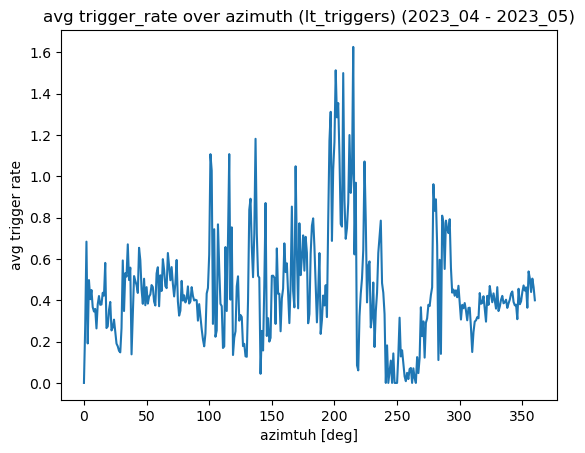

In [15]:
test = sqldf('Select avg(sum_triggers_per_second) as avg_triggers_per_sec, round(azimuth, 0) as azimuth from result_df group by round(azimuth, 0)')
plt.plot(test.azimuth, test.avg_triggers_per_sec)
plt.title('avg trigger_rate over azimuth (lt_triggers) (2023_04 - 2023_05)')
plt.xlabel('azimtuh [deg]')
plt.ylabel('avg trigger rate')
plt.savefig(f'trigger_rate_over_azimuth_station_{STATION_NR}_2023_04.pdf')

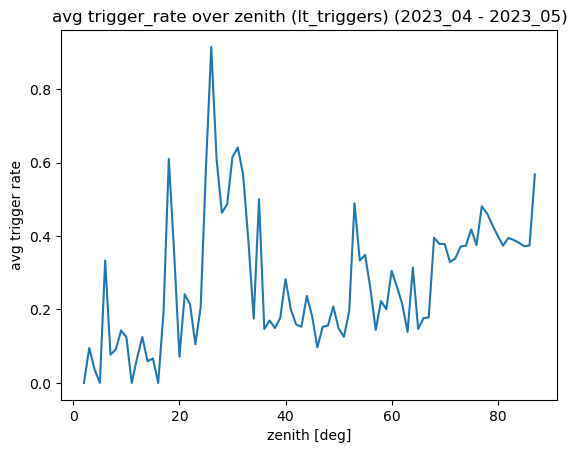

In [16]:
test = sqldf('Select avg(sum_triggers_per_second) as avg_triggers_per_sec, round(zenith, 0) as zenith from result_df group by round(zenith, 0)')
plt.plot(test.zenith, test.avg_triggers_per_sec)
plt.title('avg trigger_rate over zenith (lt_triggers) (2023_04 - 2023_05)')
plt.xlabel('zenith [deg]')
plt.ylabel('avg trigger rate')
plt.savefig(f'trigger_rate_over_zenith_station_{STATION_NR}_2023_04.pdf')